In [8]:
from data import Portfolio, Dataset
from utils import *
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [2]:
# define stock list of portfolio
stock_list = ['AXP', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'XOM', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', \
	'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'RTX', 'VZ', 'V', 'WBA', \
	'WMT', 'DIS']

# define desired start and end dates
start = '1990-01-01'
end = '2020-01-01'

# construct pandas dataframe of portfolio returns to instantiate Portfolio object 
# (in this case from yfinance)
returns = yf.Ticker('^DJI').history(start=start,end=end)

# construct Portfolio object implemented in data.py
dowjones = Portfolio('^DJI', stock_list, returns, start=start,end=end)

Before proceeding with our analysis, we can graph the historic returns of our stocks using the price_plot() class method of our Portfolio object. We choose to use the Open price as an example here, but we can also choose to graph the Close, High, or Low prices as well. We first plot the returns of the portfolio itself (in this case, just the Dow Jones index).

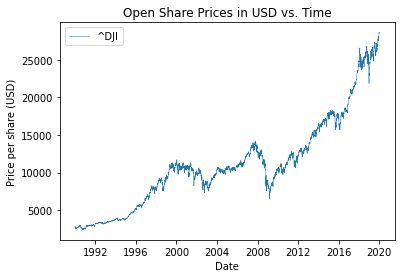

In [3]:
ax1 = dowjones.price_plot(['returns'],'Open',start,end)
plt.show()

We can plot the historical price of a few stocks for reference: in this case, the canonical tech and finance stocks.  

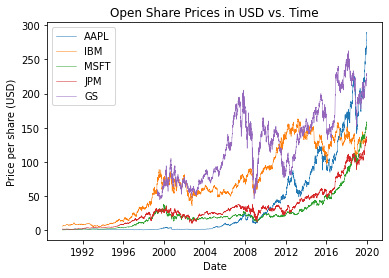

In [4]:
ax1 = dowjones.price_plot(['AAPL', 'IBM', 'MSFT','JPM', 'GS'],'Open',start,end)
plt.show()

**Feature space:** We now proceed to constructing the features that will be used to predict the movement of the Dow Jones. As per described in Krauss et al., 2016, we consider the price process $P^s_{t \in T}$ for a stock $s$, and define the return over a period of duration $m$ as:

$$R^s_{t,m} = \frac{P^s_t}{P^s_{t-m}} - 1$$

In considering daily data, as suggested in the paper, we consider $m \in \{1, \cdots 20\} \cup \{40, 60, \cdots, 240 \}$. This amounts to first focusing on the returns of the first 20 days (high resolution), and then consider multi-period returns corresponding to longer time scales (low resolution). This yields a total of 31 features for each stock.

**Output space:** In a slight deviation from the paper, we instead construct a binary response variable $Y^r_{t+1, 1} \in \{0, 1\}$ where $r$ represents the returns of the portfolio; in this simple example, we consider the movement of the Dow Jones index based on the previous day. That is, if the price goes up on day $t+1$, $Y^r_{t+1, 1} = 1$, and if it goes down, $Y^r_{t+1, 1} = 0$.

**Dataset generation:** We now instantiate a dataset consisting of our desired periods and features (stocks) using the implemented Dataset class. Note that the implemented class is flexible to target and feature choice, as well as period selection.

In [5]:
# define feature names, target name, periods
feature_names = stock_list
target_name = 'returns'
periods = list(range(1,21)) + list(range(40,260,20))

# instantiate data object 
dowjones_data = Dataset(dowjones, 'Open', feature_names, periods, target_name)

In [6]:
print("Number of features", dowjones_data.n_features)
print("Number of classes", dowjones_data.n_classes)
print("Number of datapoints", dowjones_data.n_samples)

Number of features 900
Number of classes 2
Number of datapoints 7318


Our feature matrix is thus 7318 x 900 in dimension. We first explore the summary statistics of our features by invoking the .statistics() instance method (also flexible with respect to feature and period selection). As an exercise, we display the summary statistics of the 10-day returns for the stocks plotted above. 

In [7]:
df_stat = dowjones_data.statistics(features=['AAPL', 'IBM', 'MSFT','JPM', 'GS'],periods=[10])
display(df_stat)

,"(AAPL, 10)","(IBM, 10)","(MSFT, 10)","(JPM, 10)","(GS, 10)"
count,7318.000000,7318.000000,7318.000000,7318.000000,5190.000000
mean,0.011394,0.005136,0.009127,0.009057,0.004749
std,0.086559,0.052908,0.056994,0.067206,0.063705
var,0.007492,0.002799,0.003248,0.004517,0.004058
kurtosis,5.965171,2.781818,2.425856,6.285873,3.981627
skewness,0.026533,0.188881,0.252276,0.583260,0.089509
min,-0.623978,-0.254252,-0.286087,-0.398408,-0.371436
25%,-0.036649,-0.023505,-0.022482,-0.026124,-0.030898
50%,0.010659,0.004078,0.008821,0.007694,0.005059
75%,0.057579,0.033045,0.038832,0.042125,0.037890


[TODO] some analysis about the summary statistics displayed here

We can also construct a correlation matrix from the data by invoking the corr_plot() instance method on our object: 

[TODO: correlation matrix is very slow in Jupyter]

In [11]:
dowjones_data.data

array([[ 0.02857143,  0.01694915,  0.00558659, ..., -0.0094518 ,
         0.03353057, -0.04900181],
       [-0.02222222,  0.00571429, -0.00564972, ...,  0.00574713,
         0.04373757, -0.04891304],
       [-0.02272727, -0.04444444, -0.01714286, ..., -0.01328273,
         0.05906314, -0.05626134],
       ...,
       [ 0.00686259,  0.00710652,  0.0008025 , ...,  0.29545858,
         0.35331727,  0.31647738],
       [-0.00505172,  0.0017762 ,  0.0020189 , ...,  0.28845474,
         0.3430704 ,  0.32379655],
       [-0.00725338, -0.01226846, -0.00549007, ...,  0.28655861,
         0.3054975 ,  0.31349424]])